### Bermudan Option Parameters

- **Initial stock price**: \( S_0 = 36 \)  
- **Strike price**: \( K = 40 \)  
- **Risk-free rate**: \( r = 0.06 \)  
- **Volatility**: 20%  
- **Maturity**: \( T = 1 \) year  
- **Number of exercise dates**: \( N = 50 \)  
- **Number of Monte Carlo simulations**: \( M = 10,000 \) (different number of scenarios for specific problem)


### Longstaff Method For Option Pricing

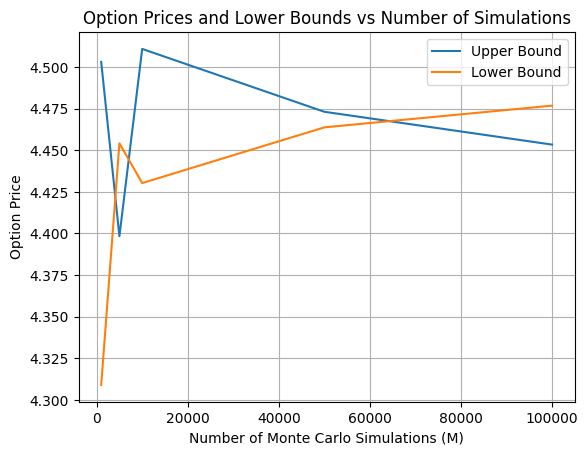

In [ ]:
import numpy as np

# Parameters
S0 = 36  # Initial stock price
K = 40   # Strike price
r = 0.06 # Risk-free rate
sigma = 0.2 # Volatility
T = 1.0  # Maturity in years
N = 50   # Number of exercise dates
M = 10000 # Number of Monte Carlo simulations

# Time step
dt = T / N

# Simulate stock price paths
#np.random.seed(42)  # For reproducibility
def option_price(M):
    S = np.zeros((M, N + 1))
    S[:, 0] = S0
    for t in range(1, N + 1):
        Z = np.random.standard_normal(M)
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Discount factor
    discount = np.exp(-r * dt)

    # Initialize cashflows
    cashflows = np.maximum(K-S[:, -1] , 0)
    regression_coeff = np.zeros((N, 3))
    # Backward induction
    for t in range(N - 1, 0, -1):
        # In-the-money paths
        in_the_money = S[:, t] < K
        X = S[in_the_money, t]
        Y = cashflows[in_the_money] * discount
        
        # Regression to estimate continuation value
        if len(X) > 0:
            A = np.vstack([np.ones_like(X), X, X**2]).T
            coeff = np.linalg.lstsq(A, Y, rcond=None)[0]
            continuation_value = coeff[0] + coeff[1] * X + coeff[2] * X**2
            regression_coeff[t] = coeff
            # Exercise decision
            exercise_value = K - X
            exercise = exercise_value > continuation_value
            cashflows[in_the_money] = np.where(exercise, exercise_value, cashflows[in_the_money] * discount)

        # Discount remaining cashflows
        cashflows[~in_the_money] *= discount
     
    # Option price
    bermudan_option_price = np.mean(cashflows) * np.exp(-r * dt)

   
    return bermudan_option_price, regression_coeff

#Calculate lower bound on option price using different set of M paths, using the same regression coefficients
def lower_bound_option_price(M, regression_coeff):
    S = np.zeros((M, N + 1))
    S[:, 0] = S0
    for t in range(1, N + 1):
        Z = np.random.standard_normal(M)
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Discount factor
    discount = np.exp(-r * dt)

    # Initialize cashflows
    cashflows = np.maximum(K - S[:, -1] , 0)*discount**(N)
    
    #For each path, go forward from time 1 to N, exercise when exercise value is greater than continuation value calculated using regression coefficients
    for i in range(M):
        for t in range(1,N):
            X = S[i, t]
            if X > K:
                continue
            # Calculate continuation value using regression coefficients
            A = np.array([1, X, X**2])
            continuation_value = np.dot(regression_coeff[t], A)
            
            # Exercise decision
            exercise_value = K - X
            exercise = exercise_value > continuation_value
            if exercise:
                cashflows[i] = exercise_value*(discount**(t))
                break
    # Option price
    lower_bound_price = np.mean(cashflows)
    
    return lower_bound_price
import matplotlib.pyplot as plt

M_values = [1000, 5000, 10000, 50000, 100000]
prices = [option_price(M) for M in M_values]
option_prices = [price[0] for price in prices]
lower_bound_prices = [lower_bound_option_price(M,prices[-1][-1]) for M in M_values]
plt.plot(M_values, option_prices, label = 'Upper Bound')
plt.xlabel('Number of Monte Carlo Simulations (M)')
plt.ylabel('Option Price')
plt.title('Option Prices and Lower Bounds vs Number of Simulations')
plt.grid(True)


plt.plot(M_values, lower_bound_prices, label='Lower Bound')
plt.legend()

plt.show()

In [21]:
option_prices

[4.5030562126718925,
 4.3983551379692,
 4.510851427974251,
 4.47309118869203,
 4.453366131522984]

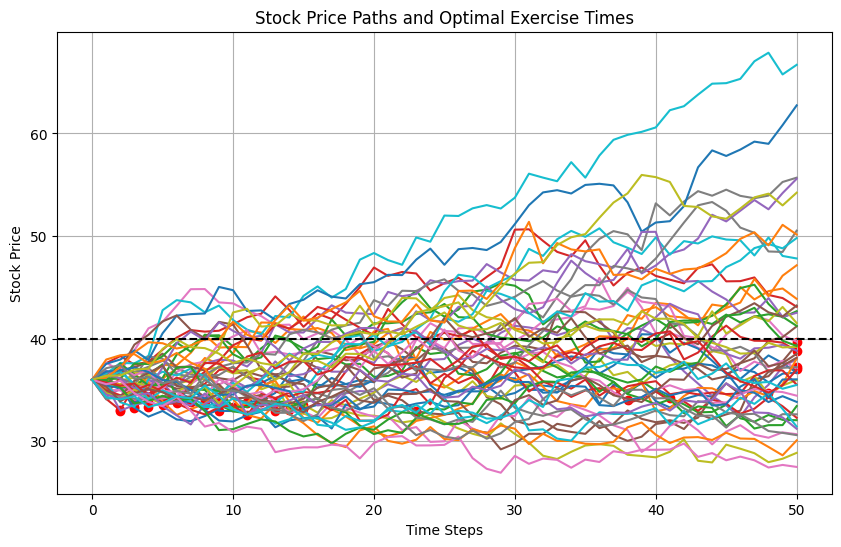

In [22]:
regression_coeff = prices[-1][-1]
# Simulate 10 stock price paths
np.random.seed(42)  # For reproducibility
num_paths = 50
S = np.zeros((num_paths, N + 1))
S[:, 0] = S0
for t in range(1, N + 1):
    Z = np.random.standard_normal(num_paths)
    S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

# Determine optimal exercise times
optimal_exercise_times = []
for i in range(num_paths):
    exercise_time = N if S[i, -1] < K else None
    for t in range(1, N):
        X = S[i, t]
        if X > K:
            continue
        A = np.array([1, X, X**2])
        continuation_value = np.dot(regression_coeff[t], A)
        exercise_value = K - X
        if exercise_value > continuation_value:
            exercise_time = t
            break
    optimal_exercise_times.append(exercise_time)

# Plot stock paths and optimal exercise times
plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(range(N + 1), S[i], label=f'Path {i + 1}')
    if optimal_exercise_times[i] is not None:
        plt.scatter(optimal_exercise_times[i], S[i, optimal_exercise_times[i]], color='red', label=f'Exercise Path {i + 1}' if i == 0 else "")

plt.axhline(y=K, color='black', linestyle='--', label='Strike Price (K)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Stock Price Paths and Optimal Exercise Times')
#plt.legend()
plt.grid(True)
plt.show()